<a href="https://colab.research.google.com/github/ikechiamaka/Access-control-with-voice-recognition-and-RFID-/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade google-cloud-vision pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.1/526.1 kB 22.8 MB/s eta 0:00:00


In [30]:
!pip install rapidfuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.8 MB/s eta 0:00:00


In [31]:
# Authentication to Google API
import os
import math
from collections import Counter
from google.cloud import vision
import re

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/content/luxeladies-820fc41b1579.json'
WORD = re.compile(r"\w+")

In [32]:
def detect_text(path):
    """Detects text in the file."""

    client = vision.ImageAnnotatorClient()

    with open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # for non-dense text
    # response = client.text_detection(image=image)
    # for dense text
    response = client.document_text_detection(image=image)
    texts = response.text_annotations
    ocr_text = []

    for text in texts:
        ocr_text.append(f"\r\n{text.description}")

    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
        )
    return ocr_text

In [42]:
image_path = "/content/ocw.jpg"
text = detect_text(image_path)

In [43]:
text[0]

'\r\nSW 1.0.1\nSERIAL NO. 277699\nMAX W.P. 300PSI/20.7BAR\nMODEL\n3051CG4A02A1AS5M5D4\nCAL. 0 TO 150 PSI\nROSE\nCHANHAS\nX\nHART 4-20mA\nFOUNDATION\nSUPPLY\n10.5-424 VDC\nFieldbus\nSUPPLY\n32 VDC\nPROFIBUS-PA 17.5 mA'

In [44]:
raw_text = text[0]  # The full recognized text from Google Vision
lines = raw_text.splitlines()

for i, line in enumerate(lines):
    print(f"{i}: {line}")


0: 
1: SW 1.0.1
2: SERIAL NO. 277699
3: MAX W.P. 300PSI/20.7BAR
4: MODEL
5: 3051CG4A02A1AS5M5D4
6: CAL. 0 TO 150 PSI
7: ROSE
8: CHANHAS
9: X
10: HART 4-20mA
11: FOUNDATION
12: SUPPLY
13: 10.5-424 VDC
14: Fieldbus
15: SUPPLY
16: 32 VDC
17: PROFIBUS-PA 17.5 mA


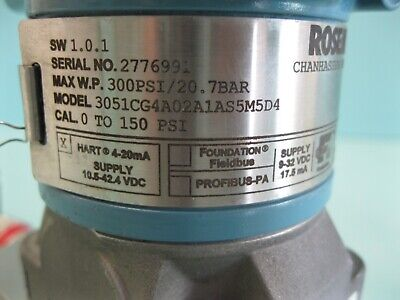

In [45]:
from PIL import Image, ImageDraw
image=Image.open(image_path)
image

In [49]:
from rapidfuzz import process, fuzz
# Known label variants (case-insensitive) that might appear in the OCR text
known_labels = [
    "MODEL", "MDL",
    "MODEL S/N", "MODEL SN",
    "SENSOR S/N", "SENSOR SN",
    "SERIAL NO", "SERIAL #",
    "CAL#", "CAL NO"
]

# Map each known label to a canonical field name in our extracted data
label_map = {
    "MODEL": "model",
    "MDL": "model",
    "MODEL S/N": "model_sn",
    "MODEL SN": "model_sn",
    "SENSOR S/N": "sensor_sn",
    "SENSOR SN": "sensor_sn",
    "SERIAL NO": "serial_no",
    "SERIAL #": "serial_no",
    "CAL#": "cal_no",
    "CAL NO": "cal_no"
}


In [50]:
def detect_text_lines(image_path):
    """
    Performs OCR using Google Cloud Vision (document_text_detection).
    Returns a list of lines from the recognized text.
    """
    client = vision.ImageAnnotatorClient()
    with open(image_path, "rb") as f:
        content = f.read()

    image = vision.Image(content=content)
    response = client.document_text_detection(image=image)
    if response.error.message:
        raise Exception(response.error.message)

    texts = response.text_annotations
    if not texts:
        return []

    # texts[0].description is the full recognized text as a single string
    full_text = texts[0].description
    # Split into lines
    lines = full_text.splitlines()
    return lines

def fuzzy_parse_lines_with_lookahead(lines, known_labels, label_map, threshold=70):
    """
    1. Fuzzy-match the first 1-2 tokens of each line to find a label.
    2. If the label has no value tokens on the same line, look at the next line for a potential value.
    3. Return a dict of extracted fields.
    """
    from rapidfuzz import process, fuzz

    extracted = {}
    skip_next_line = False

    for i in range(len(lines)):
        if skip_next_line:
            skip_next_line = False
            continue

        line = lines[i].strip()
        tokens = line.split()
        if not tokens:
            continue

        # Build label candidates from the first 1 or 2 tokens
        label_candidates = []
        for tcount in range(1, min(len(tokens), 2) + 1):
            candidate_label = " ".join(tokens[:tcount]).upper()
            # Remove punctuation from candidate label
            candidate_label = re.sub(r'[^\w\s]', '', candidate_label)
            label_candidates.append(candidate_label)

        best_score = 0
        best_known_label = None

        # Fuzzy-match each candidate against known_labels
        for candidate in label_candidates:
            match, score, _ = process.extractOne(candidate, known_labels, scorer=fuzz.ratio)
            if score > best_score:
                best_score = score
                best_known_label = match

        # If no label found above threshold, skip
        if best_score < threshold or not best_known_label:
            continue

        # We have a label on this line. Let's see if there's a value on the same line.
        label_word_count = len(best_known_label.split())
        value_tokens = tokens[label_word_count:]  # after the label

        if value_tokens:
            # There's a value on the same line
            value = " ".join(value_tokens).replace(":", "").strip()
        else:
            # No value on the same line. Look at the NEXT line for the value
            value = ""
            if i + 1 < len(lines):
                next_line = lines[i + 1].strip()
                # If next line is a single token or some alphanumeric text, treat it as the value
                # Adjust the regex or logic as needed
                if re.match(r'^[A-Za-z0-9\-/.:]+$', next_line):
                    value = next_line
                    # We'll skip processing the next line again
                    skip_next_line = True

        # Convert matched label to canonical field name
        field_name = label_map.get(best_known_label, best_known_label.lower())
        extracted[field_name] = value

    return extracted


In [52]:
# Suppose you've uploaded "my_instrument_label.jpg" to Colab at /content/my_instrument_label.jpg

# 1. Perform OCR to get lines
lines = detect_text_lines(image_path)
print("=== OCR LINES ===")
for i, line in enumerate(lines):
    print(f"{i}: {line}")

# 2. Fuzzy parse the lines
results = fuzzy_parse_lines(lines, known_labels, label_map, threshold=70)
print("\n=== Fuzzy-Matched Results ===")
for field, value in results.items():
    print(f"{field}: {value}")


=== OCR LINES ===
0: SW 1.0.1
1: SERIAL NO. 277699
2: MAX W.P. 300PSI/20.7BAR
3: MODEL
4: 3051CG4A02A1AS5M5D4
5: CAL. 0 TO 150 PSI
6: ROSE
7: CHANHAS
8: X
9: HART 4-20mA
10: FOUNDATION
11: SUPPLY
12: 10.5-424 VDC
13: Fieldbus
14: SUPPLY
15: 32 VDC
16: PROFIBUS-PA 17.5 mA

=== Fuzzy-Matched Results ===
serial_no: 277699
model: 
cal_no: 0 TO 150 PSI
